In [1]:
from datetime import datetime, timezone
from string import Template
import geopandas as gpd
import pandas as pd
from pyhive import hive


In [3]:
import os
os.getcwd()

'c:\\Users\\max-d\\Documents\\Maitrise_informatique\\Stage\\Menya\\miw_distributed_GIS\\spatial-analytics\\app'

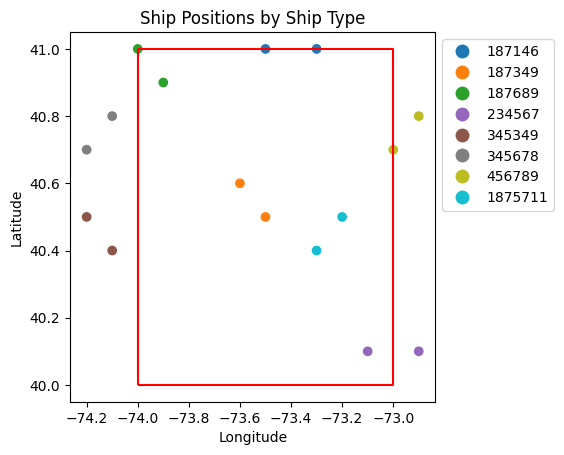

In [51]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('../hivedb/shared_data/test/message_19_test_geo_2.csv')

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# Set the coordinate reference system (CRS) if needed, e.g., WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Define the polygon points
polygon_points = [(-74., 40), (-73, 40),       ( -73, 41),      (-74, 41)]
        # (-74.010, 40.710), (-73.9950, 40.710), (-73.9950, 40.720), (-74.0100, 40.720)
polygon = Polygon(polygon_points)

# Create a GeoDataFrame for the polygon
polygon_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])


# Plot the GeoDataFrame with ship type in different colors
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='mmsi', legend=True, categorical=True, legend_kwds={'bbox_to_anchor': (1, 1)})
polygon_gdf.boundary.plot(ax=ax, color='red')
ax.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ship Positions by Ship Type')
plt.show()

In [2]:
def connect_to_hive(host='localhost', port=10000, database='default'):
    """
    Connect to Hive with explicit host, port, and database
    
    Args:
        host (str): Hive server hostname
        port (int): Hive server port
        database (str): Target database name
    
    Returns:
        hive.Connection: Hive connection object
    """
    conn = hive.Connection(
        host=host,
        port=port,
        database=database
    )
    
    return conn

def exect_hql_command(command: str, host='localhost', port=10_000, database='default'):
    """Execute the HQL command. Don't add the typical ';' at the end of your command"""
    try:
        connection = connect_to_hive(
            host=host, 
            port=port, 
            database=database  # Specify default or your database name
        )
        
        cursor = connection.cursor()
        
        # Example query
        cursor.execute(command)
        results = cursor.fetchall()
        print(results)
        
    except Exception as e:
        print(f"Connection error: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()

# Few query examples:
We use the Template class from the string librairy

In [12]:
min_max_template = Template("SELECT MIN($column) AS min_value, MAX($column) AS max_value FROM $table")

In [14]:
formatted_query = min_max_template.substitute(column="speed", table="message1")

exect_hql_command(formatted_query)

[(0.0, 102.3)]


In [15]:
formatted_query = min_max_template.substitute(column="receiver_timestamp", table="message1")

exect_hql_command(formatted_query)

[(1732584019, 1732585217)]


In [16]:
print(datetime.fromtimestamp(1732584019, tz=timezone.utc))
print(datetime.fromtimestamp(1732585217, tz=timezone.utc))


2024-11-26 01:20:19+00:00
2024-11-26 01:40:17+00:00


In [2]:
s = "2024-11-26 01:25:19+00:00"
start = int(datetime.strptime(s, "%Y-%m-%d %H:%M:%S%z").timestamp())
e = "2024-11-26 01:30:17+00:00"
end = int(datetime.strptime(e, "%Y-%m-%d %H:%M:%S%z").timestamp())
print(start, end)

1732584319 1732584617


In [17]:
s = "2024-11-26 01:25:19+00:00"
start = int(datetime.strptime(s, "%Y-%m-%d %H:%M:%S%z").timestamp())
e = "2024-11-26 01:30:17+00:00"
end = int(datetime.strptime(e, "%Y-%m-%d %H:%M:%S%z").timestamp())

# All vessels travelling over a specific speed between two date-times.
query_template_vessel_speeding = Template("select mmsi, speed, lon, lat from $table where speed >=1.0 and receiver_timestamp > $lower_bound and receiver_timestamp < $higher_bound")

formatted_query = query_template_vessel_speeding.substitute(lower_bound=start, higher_bound=end, table="message1")
exect_hql_command(formatted_query)

[('257104330', 8.4, 25.799232, 70.78259), ('308785000', 15.6, 15.68385, 68.248085), ('258270500', 102.3, 18.1464, 69.15718), ('258062000', 7.6, 5.55713, 58.59874), ('257806000', 4.2, 10.81304, 68.07669), ('212770000', 18.3, 4.18142, 60.932934), ('259563000', 6.1, 15.276162, 69.33594), ('219945000', 16.8, 10.981617, 58.017715), ('258470000', 1.9, 22.322477, 70.862686), ('259968000', 8.8, 10.258275, 66.06059), ('220151000', 2.4, 8.180505, 57.63847), ('314985000', 8.5, 13.25059, 69.17763), ('257039730', 6.9, 5.724497, 59.995403), ('259704000', 12.2, 4.967097, 60.8426), ('309481000', 10.2, 4.188748, 62.218987), ('259004230', 5.6, 8.69291, 63.43947), ('258467000', 9.8, 4.987818, 60.476704), ('257744000', 9.5, 8.31017, 63.329033), ('257602000', 2.0, 17.493357, 69.49611), ('257152000', 7.7, 5.398938, 59.12895), ('266322000', 2.8, 10.47164, 58.596474), ('258147000', 9.0, 16.462934, 69.63007), ('257090560', 7.9, 6.331655, 62.40818), ('257872000', 10.1, 5.405733, 62.719673), ('259252000', 4.3, 1

In [18]:
exect_hql_command("SHOW COLUMNS FROM message1")

[('msg_type',), ('receiver_timestamp',), ('repeated',), ('mmsi',), ('status',), ('turn',), ('speed',), ('accuracy',), ('lon',), ('lat',), ('course',), ('heading',), ('second',), ('maneuver',), ('spare_1',), ('raim',), ('radio',)]


In [19]:
query_describe_table = Template("DESCRIBE EXTENDED $table")

formatted_query = query_describe_table.substitute(table="message1")
exect_hql_command(formatted_query)

[('msg_type', 'int', 'Type for message range from 1 to 27. Here alway 1.'), ('receiver_timestamp', 'int', 'Metadata: timestamp when the message was received'), ('repeated', 'int', "Alias to 'repeat'. how many times a message has been repeated (0-3). The number of stations received the message."), ('mmsi', 'string', 'Unique number to identify the ship.'), ('status', 'int', 'Navigational status: 0 = using engine, 1 = at anchor, 2 = not under command, 3 = restricted maneuverability, 4 = constrained draught, 5 = moored, 6 = aground, 7 = fishing, 8 = under way sailing'), ('turn', 'int', 'Rate of turn. positive = turn right, negative = turn left. -128 = default no information available'), ('speed', 'double', 'Speed over ground SOG in Knots'), ('accuracy', 'int', 'position accuracy: 1 = high (<= 10 m), 0 = low (> 10 m), 0 = default'), ('lon', 'float', "Longitude in 1/10 000 min, (+/-180 deg, East = positive (as per 2's complement), West = negative"), ('lat', 'float', 'Latitude in 1/10 000 min

In [20]:
# All MMSI’s and positions where “received stations” are greater than 1.
query__received_stations = Template("SELECT mmsi, lon, lat, repeated from $table WHERE repeated >= 1")

formatted_query = query__received_stations.substitute(table="message1")

exect_hql_command(formatted_query)

[('258874000', 23.800377, 74.25528, 1), ('257271600', 21.610752, 74.20789, 1), ('259457000', 18.339672, 73.669815, 1), ('257317000', 21.412863, 74.18254, 1), ('613115900', 18.374117, 73.74358, 1), ('257225000', 18.418848, 74.99592, 1), ('273428880', 13.872098, 76.54181, 1), ('258563000', 22.236717, 74.170166, 1), ('273437550', 16.05096, 75.182594, 1), ('257786700', 22.013494, 74.13216, 1), ('275492000', 23.634783, 74.644585, 1), ('231867000', 20.453476, 74.17212, 1), ('258732000', 21.150768, 74.3116, 1), ('258874000', 23.793608, 74.25452, 1), ('257317000', 21.408632, 74.18435, 1), ('257225000', 18.42237, 74.99505, 1), ('259457000', 18.332523, 73.67417, 1), ('613115900', 18.3792, 73.73842, 1), ('258535000', 23.281033, 74.22863, 1), ('273428880', 13.87798, 76.5406, 1), ('257786700', 22.00932, 74.13063, 1), ('273437550', 16.046173, 75.180725, 1), ('275492000', 23.627388, 74.64469, 1), ('258778000', 20.953655, 74.2792, 1), ('258874000', 23.786552, 74.25374, 1), ('257271600', 21.610062, 74.

In [22]:
# All MMSI’s and positions where “received stations” are greater than 1 and
# count the number of vessels within 20, 50, 80 km of that MMSI.
exect_hql_command("""
WITH selected_ships AS (
    -- Select ships with repeated > 0
    SELECT 
        mmsi AS base_mmsi,
        lon AS base_lon,
        lat AS base_lat,
        repeated AS base_repeated
    FROM message1
    WHERE repeated > 0
),
nearby_ships AS (
    SELECT 
        m.mmsi,
        m.lon,
        m.lat,
        m.repeated,
        s.base_mmsi,
        s.base_lon,
        s.base_lat,
        s.base_repeated,
        -- Using ST_Distance for spatial distance calculation
        ST_Distance(
            ST_Point(s.base_lon, s.base_lat), 
            ST_Point(m.lon, m.lat)
        ) AS distance
    FROM message1 m
    CROSS JOIN selected_ships s
    WHERE 
        m.mmsi != s.base_mmsi AND
        ST_Distance(
            ST_Point(s.base_lon, s.base_lat), 
            ST_Point(m.lon, m.lat)
        ) <= 20  -- Distance in kilometers, might need to change that
)

SELECT 
    base_mmsi,
    base_lon,
    base_lat,
    base_repeated,
    COUNT(DISTINCT mmsi) AS nearby_ships_count
FROM nearby_ships
GROUP BY 
    base_mmsi,
    base_lon,
    base_lat,
    base_repeated
ORDER BY 
    nearby_ships_count DESC""")

[('273437550', 16.040983, 75.17886, 1, 1651), ('273437550', 16.012766, 75.16965, 1, 1651), ('273437550', 16.026978, 75.17372, 1, 1651), ('273437550', 16.031288, 75.17536, 1, 1651), ('273437550', 16.046173, 75.180725, 1, 1650), ('273437550', 16.05096, 75.182594, 1, 1650), ('273213010', 16.0905, 75.23554, 1, 1648), ('273213010', 16.0906, 75.23795, 1, 1648), ('259457000', 18.302101, 73.69236, 1, 1642), ('259457000', 18.332523, 73.67417, 1, 1642), ('259457000', 18.339672, 73.669815, 1, 1642), ('259457000', 18.308617, 73.6885, 1, 1642), ('259457000', 18.281591, 73.70458, 1, 1642), ('259457000', 18.288029, 73.70093, 1, 1642), ('259457000', 18.295462, 73.69634, 1, 1642), ('613115900', 18.374117, 73.74358, 1, 1640), ('613115900', 18.3842, 73.7335, 1, 1640), ('257097470', 16.613337, 75.20513, 1, 1640), ('613115900', 18.3792, 73.73842, 1, 1640), ('613115900', 18.404583, 73.71435, 1, 1640), ('613115900', 18.41015, 73.70928, 1, 1640), ('257097470', 16.612864, 75.210045, 1, 1640), ('273428880', 13.

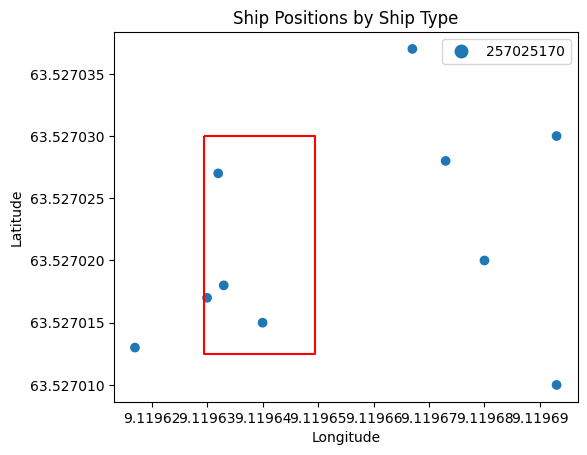

In [68]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('../hivedb/shared_data/norvegian_20_min/message_1.csv')
df['datetime'] = pd.to_datetime(df['receiver_timestamp'], unit='s', utc=True)
df['mmsi'].unique()

df_bis = df[df['mmsi'] == 257025170][['mmsi', 'speed', 'lon', 'lat', 'datetime']]
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_bis, 
    geometry=gpd.points_from_xy(df_bis.lon, df_bis.lat)
)

# Set the coordinate reference system (CRS) if needed, e.g., WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Define the polygon points
polygon_points = [(9.1196295, 63.52703), (9.1196495, 63.52703), (9.11964950000000, 63.5270125), ( 9.1196295, 63.5270125)]
polygon = Polygon(polygon_points)

# Create a GeoDataFrame for the polygon
polygon_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])


# Plot the GeoDataFrame with ship type in different colors
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='mmsi', legend=True, categorical=True, legend_kwds={'bbox_to_anchor': (1, 1)})
polygon_gdf.boundary.plot(ax=ax, color='red')
ax.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ship Positions by Ship Type')
plt.show()



In [70]:
df_bis

,mmsi,speed,lon,lat,datetime
0,257025170,0.0,9.119630,63.527017,2024-11-26 01:20:19+00:00
1592,257025170,0.0,9.119633,63.527018,2024-11-26 01:22:28+00:00
3315,257025170,0.0,9.119640,63.527015,2024-11-26 01:24:49+00:00
4893,257025170,0.0,9.119673,63.527028,2024-11-26 01:26:57+00:00
6357,257025170,0.0,9.119667,63.527037,2024-11-26 01:28:58+00:00
7832,257025170,0.0,9.119693,63.527030,2024-11-26 01:30:58+00:00
9421,257025170,0.0,9.119693,63.527010,2024-11-26 01:33:08+00:00
10995,257025170,0.0,9.119680,63.527020,2024-11-26 01:35:18+00:00
12592,257025170,0.0,9.119632,63.527027,2024-11-26 01:37:27+00:00
14069,257025170,0.0,9.119617,63.527013,2024-11-26 01:39:27+00:00
